# Stock Foreasting for MU stock

In [1]:
import datetime as dt

In [2]:
import pandas as pd
import numpy as np

In [3]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader.data import DataReader

In [4]:
end = dt.datetime.now()

In [5]:
#Taking 5 years of data till date
start = end - dt.timedelta(days=5*365)

In [6]:
#importing MU data from IEX
df = DataReader('MU','iex',start,end)

5y


In [7]:
df.head()

,open,high,low,close,volume
date,,,,,
2013-10-15,17.08,17.43,16.84,16.920,63043897
2013-10-16,17.08,17.30,16.91,16.960,49096355
2013-10-17,17.00,17.16,16.74,17.145,40714771
2013-10-18,17.17,17.25,16.96,17.029,34970601
2013-10-21,17.03,17.14,16.51,16.565,44886230


In [8]:
df.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,28.362914,28.802636,27.870288,28.337052,3.132442e+07
std,12.703094,12.884766,12.463976,12.683826,1.599719e+07
min,9.610000,9.690000,9.310000,9.560000,4.672964e+06
25%,17.745000,17.990000,17.380000,17.650000,2.119935e+07
50%,27.220000,27.550000,26.860000,27.140000,2.720240e+07
75%,33.670000,34.040000,33.170000,33.675000,3.693571e+07
max,63.700000,64.660000,61.350000,62.620000,1.490103e+08


In [9]:
df.shape

(1259, 5)

# Implement features from table 1 and 2 and visualize

In [10]:
#creating a 1 day ahead forecast column for close price called label
df['label'] = df['close'].shift(-1)

In [11]:
#Calculating momentum
df['momentum'] = df.close - df.close.shift(4)

In [12]:
#average return in the last 3 days
df['ASY3'] = (df.close - df.close.shift(1)).rolling(3).sum()/3

In [13]:
#average return in the last 2 days
df['ASY2'] = (df.close - df.close.shift(1)).rolling(2).sum()/2

In [14]:
df['return'] = (df.close - df.close.shift(1))

In [15]:
#average return in the last 1 day
df['ASY1']  = df['return'].shift(1)

In [16]:
#moving average with no of observations: 5
df['MA5'] = df['close'].rolling(5).mean()

In [17]:
df.head()

,open,high,low,close,volume,label,momentum,ASY3,ASY2,return,ASY1,MA5
date,,,,,,,,,,,,
2013-10-15,17.08,17.43,16.84,16.920,63043897,16.960,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-16,17.08,17.30,16.91,16.960,49096355,17.145,NaN,NaN,NaN,0.040,NaN,NaN
2013-10-17,17.00,17.16,16.74,17.145,40714771,17.029,NaN,NaN,0.1125,0.185,0.040,NaN
2013-10-18,17.17,17.25,16.96,17.029,34970601,16.565,NaN,0.036333,0.0345,-0.116,0.185,NaN
2013-10-21,17.03,17.14,16.51,16.565,44886230,16.760,-0.355,-0.131667,-0.2900,-0.464,-0.116,16.9238


In [18]:
df.drop( columns =['open' , 'high', 'low', 'volume' , 'return'], axis =1 , inplace = True)

In [19]:
df.head()

,close,label,momentum,ASY3,ASY2,ASY1,MA5
date,,,,,,,
2013-10-15,16.920,16.960,NaN,NaN,NaN,NaN,NaN
2013-10-16,16.960,17.145,NaN,NaN,NaN,NaN,NaN
2013-10-17,17.145,17.029,NaN,NaN,0.1125,0.040,NaN
2013-10-18,17.029,16.565,NaN,0.036333,0.0345,0.185,NaN
2013-10-21,16.565,16.760,-0.355,-0.131667,-0.2900,-0.116,16.9238


In [20]:
df.dropna(inplace = True)

In [21]:
df.head()

,close,label,momentum,ASY3,ASY2,ASY1,MA5
date,,,,,,,
2013-10-21,16.565,16.760,-0.355,-0.131667,-0.2900,-0.116,16.9238
2013-10-22,16.760,16.551,-0.200,-0.128333,-0.1345,-0.464,16.8918
2013-10-23,16.551,16.830,-0.594,-0.159333,-0.0070,0.195,16.8100
2013-10-24,16.830,16.580,-0.199,0.088333,0.0350,-0.209,16.7470
2013-10-25,16.580,16.720,0.015,-0.060000,0.0145,0.279,16.6572


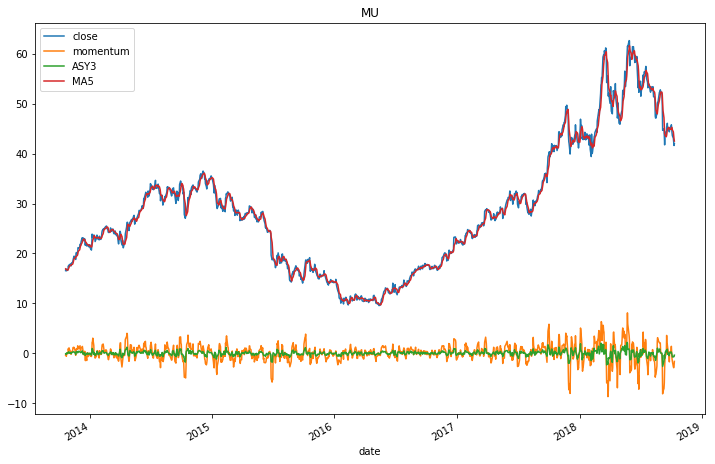

In [64]:
import matplotlib.pyplot as plt
df[['close', 'momentum','ASY3', 'MA5']].plot(figsize=(12,8), title='MU')
plt.show()

In [23]:
df.shape

(1254, 7)

# Do a regression based on the features, forecast 1-day ahead.

In [24]:
#x is the input features
x = np.array(df.drop(['label'],1))

In [25]:
#y is the target 
y = np.array(df['label'])

In [26]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [27]:
#Data pre processing scaling input features x
scaler = preprocessing.StandardScaler().fit(x)

In [28]:
x = scaler.transform(x)

In [29]:
from sklearn.model_selection import TimeSeriesSplit

In [30]:
#multiple train and test splits. Here 5 splits are created.
#Train split = i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1)
#Test split = n_samples//(n_splits + 1)
# for 5th split train set will have 1052 records..nearly 80% of data.
tscv = TimeSeriesSplit(n_splits=5)

In [31]:
for train_index,test_index in tscv.split(x):
    x_train,x_test = x[train_index],x[test_index]
    y_train,y_test = y[train_index],y[test_index]

In [32]:
#Linear least squares with l2 regularization.
linear = Ridge(alpha=1.0,tol=0.001, solver='auto')

In [33]:
linear.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
#predict the values for the new set of test inputs using the model created.
forecast = linear.predict(x_test)

In [35]:
#This the first 5 input features used for testing the model
x_test[:5]

array([[ 1.07936446, -0.71393828, -0.81967447, -0.82870095, -1.39780361,
         1.13347545],
       [ 1.09434676, -0.60949648, -0.55755761,  0.28242642,  0.203771  ,
         1.1183034 ],
       [ 1.10696344, -0.40061288,  0.32288621,  0.25755043,  0.203771  ,
         1.10550198],
       [ 1.21026248,  1.02675841,  1.07563207,  1.1862539 ,  0.16791486,
         1.11656493],
       [ 1.23155312,  1.07317699,  1.12939963,  1.27746584,  1.54240053,
         1.15006988]])

In [36]:
# This is the first 5 observed values 
y_test[:5]

array([42.24, 42.4 , 43.71, 43.98, 45.75])

In [37]:
# this is the first 5 values predicted using the model
forecast[:5]

array([42.03318485, 42.26632487, 42.39503538, 43.78103229, 43.99183606])

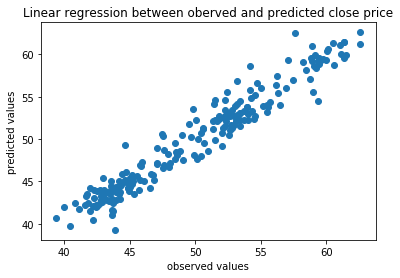

In [38]:
#scatter plot of observed and predicted values. There is a increasing linear regression between them.
import matplotlib.pyplot as plt
plt.scatter(y_test,forecast)
plt.xlabel("observed values")
plt.ylabel("predicted values")
plt.title("Linear regression between oberved and predicted close price")
plt.show()

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


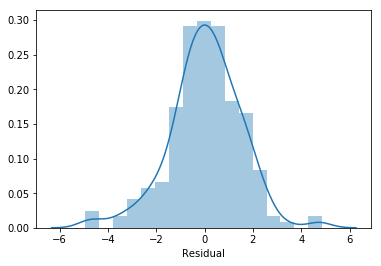

In [39]:
# Histogram plot of the residuals show that they are normally distributed.
import seaborn as sns
sns.distplot((y_test-forecast),axlabel = 'Residual')

In [40]:
#importing plotly
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username ='harinipraveen',api_key ='vL1Ykz5yY0MUcNl17psV')
import plotly.graph_objs as go

In [41]:
#formatting the date and setting the index 
df.reset_index(inplace=True)
df.date = pd.to_datetime(df['date'] ,format='%Y-%m-%d')
df.set_index(['date'], inplace=True)

In [42]:
#adding forecast values predicted for the test set to the dataframe df
end = len(df)
start = len(df) - len(y_test)
df.loc[start:end , 'forecast'] = forecast
df.tail()

,close,label,momentum,ASY3,ASY2,ASY1,MA5,forecast
date,,,,,,,,
2018-10-05,43.58,43.07,-1.57,-0.726667,-0.785,-0.99,44.760,43.513121
2018-10-08,43.07,42.27,-2.69,-0.693333,-0.545,-0.58,44.344,43.029243
2018-10-09,42.27,41.61,-2.88,-0.630000,-0.655,-0.51,43.646,42.202368
2018-10-10,41.61,41.97,-2.55,-0.656667,-0.730,-0.80,42.938,41.546639
2018-10-11,41.97,42.47,-1.61,-0.366667,-0.150,-0.66,42.500,41.989532


In [43]:
#Visualizing prediction and actual price for each date
trace1 = go.Scatter(x = df.index.to_pydatetime(),y = df.label,name = 'observed close price')
trace2 = go.Scatter(x = df.index.to_pydatetime(),y = df.forecast,name = 'predicted price')
data = [trace1,trace2]
layout = go.Layout(dict(title='MU Predicted and real close price', yaxis = {'title': 'MU Close price'},
    xaxis=dict(type='date')))
figure = go.Figure(data=data,layout=layout)
py.iplot(figure,filename ="Actual Vs predicted close price")

# Calculating metrics for forecasted values

In [44]:
from sklearn import metrics

In [45]:
#Calculating mean absolute error
print('MAE: %.3f' %metrics.mean_absolute_error(y_test,forecast))

MAE: 1.123


In [46]:
#Calculating mean squared error
print('MSE: %.3f' %metrics.mean_squared_error(y_test,forecast))

MSE: 2.215


In [47]:
#Calculating root mean square error
print('RMSE : %.3f'  %np.sqrt(metrics.mean_squared_error(y_test,forecast)))

RMSE : 1.488


In [48]:
#Calculating Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - forecast) / y_test)) * 100
print('MAPE : %.3f' %MAPE)

MAPE : 2.258


In [49]:
#coefficient of determination
#Regression predictions perfectly fit the data since it is nearly equal to 1
print('Score of linear model: %.3f' %linear.score(x_test,y_test))

Score of linear model: 0.938


In [50]:
feature_cols = df.drop(['label'],1)
print(list(zip(feature_cols, linear.coef_)))

[('close', 6.32422187150784), ('momentum', 0.16555626699314716), ('ASY3', 0.11822636816826729), ('ASY2', 0.35834147412240835), ('ASY1', -0.13252238416195736), ('MA5', 6.314903521247495)]


In [51]:
from sklearn.metrics import r2_score
print('R2Score:%.3f'%r2_score(y_test,forecast))

R2Score:0.938


In [52]:
#Calculating residual sum of squares
print("Residual sum of squares: %.2f" %np.mean(( y_test - linear.predict(x_test))**2))

Residual sum of squares: 2.22


In [53]:
#taking the test set alone as a dataframe df1 to compute confusion matrix and trading decisions.
#end = len(df)
#start = len(df) - len(y_test)
df.reset_index(inplace=True)
df1 = pd.DataFrame()
df1 = df.loc[start:end]

df.set_index(['date'], inplace=True)
df1.set_index(['date'], inplace=True)
df1.head()


,close,label,momentum,ASY3,ASY2,ASY1,MA5,forecast
date,,,,,,,,
2017-12-13,42.05,42.24,-1.15,-0.386667,-0.480,-1.15,42.666,42.033185
2017-12-14,42.24,42.40,-0.97,-0.256667,0.190,0.19,42.474,42.266325
2017-12-15,42.40,43.71,-0.61,0.180000,0.175,0.19,42.312,42.395035
2017-12-18,43.71,43.98,1.85,0.553333,0.735,0.16,42.452,43.781032
2017-12-19,43.98,45.75,1.93,0.580000,0.790,1.31,42.876,43.991836


In [54]:
# '! pip install --user pandas_ml' ---> to install pandas_ml
#confusion matrix using pandas ml
from pandas_ml import ConfusionMatrix

#defining input arrays
close_val = np.array(df1['close'])
actual_val = np.array(df1['label'])
pred_val = np.array(df1['forecast'])

#defining actual and predicted binary arrays
act = []
pred = []

for d in range (len(close_val)):
    act.append(True) if (actual_val[d] > close_val[d]) else act.append(False)
    pred.append(True) if (pred_val[d] > close_val[d]) else pred.append(False)

print('confusion matrix' ,'\n', ConfusionMatrix(act,pred))
correct =  (np.array(pred) == np.array(act)).sum()
accuracy = (correct/len(pred))*100
print('\nAccuracy: %.3f' %accuracy)



confusion matrix 
 Predicted  False  True  __all__
Actual                         
False         66    34      100
True          70    39      109
__all__      136    73      209

Accuracy: 50.239


In [55]:
#creating confusion matrix manually
act = np.array(act)
pred = np.array(pred)
TP = sum(np.bitwise_and(act==True, pred==True))
FN = sum(np.bitwise_and(act==True, pred==False))
TN = sum(np.bitwise_and(act==False, pred==False))
FP = sum(np.bitwise_and(act==False, pred==True))
correct = TP + TN
total = TP + FN + TN + FP
hitratio = (correct/total)*100
print('\nhitratio :%.3f'  %hitratio)
conf_matrix = np.array([[TN,FP],[FN,TP]])
print('confusion Matrix manually created')
print(conf_matrix)



hitratio :50.239
confusion Matrix manually created
[[66 34]
 [70 39]]


In [56]:
#creating confusion matrix manually using df1 columns --> execution time is more!!
df1['TP'] = np.nan
df1['FN'] = np.nan
df1['TN'] = np.nan
df1['FP'] = np.nan

for i in range(len(df1)):
    if (df1['label'].iloc[i] > df1['close'].iloc[i]): 
         if (df1['forecast'].iloc[i] > df1['close'].iloc[i]):
            df1['TP'].iloc[i] = 1
    if (df1['label'].iloc[i] > df1['close'].iloc[i]): 
         if (df1['forecast'].iloc[i] < df1['close'].iloc[i]):
            df1['FN'].iloc[i] = 1            
    if (df1['label'].iloc[i] < df1['close'].iloc[i]): 
         if (df1['forecast'].iloc[i] < df1['close'].iloc[i]):
            df1['TN'].iloc[i] = 1
    if (df1['label'].iloc[i] < df1['close'].iloc[i]): 
         if (df1['forecast'].iloc[i] > df1['close'].iloc[i]):
            df1['FP'].iloc[i] = 1
    

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [57]:
#creating values for confusion matrix  and calculating hit ratio
tp = df1['TP'].sum()
fn = df1['FN'].sum()
tn = df1['TN'].sum()
fp = df1['FP'].sum()
correct = tp + tn
total = tp + fn + tn + fp
hitratio = (correct/total)*100
print('\nhitratio: %.3f' %hitratio)
conf_matri = np.array([[tn,fp],[fn,tp]])
print('Confusion matrix')
print(conf_matri)


hitratio: 50.725
Confusion matrix
[[66. 32.]
 [70. 39.]]


In [58]:
#dropping unwanted columns
df1.drop(columns = ['TP', 'FN', 'TN', 'FP'], axis = 1, inplace = True)

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Design a decision for when to invest and when to sell based on your regression. 

In [59]:
#'Pi' is the prediction result for the ith trading day --> whether forecast is lagging or leading
#formula taken from the paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195/
df1['direction'] = ((df1['label'].shift(-1)-df1['label'])*(df1['forecast'].shift(-1)-df1['forecast']))

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [60]:
#creating trading decision based on direction. If forecast is predicted to go up , buy the stocks.
df1['buy'] = np.where(df1['direction']>0, '1', '0')

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [61]:
#creating trading decision based on direction. If forecast is predicted to go down, sell the stocks.
df1['sell'] = np.where(df1['direction']<0, '1', '0')

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [62]:
#Determining the quality of output is to measure the correct state, e.g. the hit rate:
#formula taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195/
hit_ratio = df1['direction'].mean()*100

print('prediction performance Hit ratio' ,'{0:.2f}'.format(hit_ratio))

prediction performance Hit ratio 2.05


In [63]:
#printing the first 50 rows to show the sell buy decision. 
df1.head(50)

,close,label,momentum,ASY3,ASY2,ASY1,MA5,forecast,direction,buy,sell
date,,,,,,,,,,,
2017-12-13,42.05,42.24,-1.15,-0.386667,-0.480,-1.15,42.666,42.033185,0.037302,1,0
2017-12-14,42.24,42.40,-0.97,-0.256667,0.190,0.19,42.474,42.266325,0.168611,1,0
2017-12-15,42.40,43.71,-0.61,0.180000,0.175,0.19,42.312,42.395035,0.374219,1,0
2017-12-18,43.71,43.98,1.85,0.553333,0.735,0.16,42.452,43.781032,0.373123,1,0
2017-12-19,43.98,45.75,1.93,0.580000,0.790,1.31,42.876,43.991836,-2.437980,0,1
2017-12-20,45.75,44.42,3.51,1.116667,1.020,0.27,43.616,45.824904,0.453480,1,0
2017-12-21,44.42,44.12,2.02,0.236667,0.220,1.77,44.052,44.313304,0.564660,1,0
2017-12-22,44.12,42.25,0.41,0.046667,-0.815,-1.33,44.396,44.011346,-0.436233,0,1
2017-12-26,42.25,42.48,-1.73,-1.166667,-1.085,-0.30,44.104,42.114682,-0.232607,0,1
